### Deep mutational screen - example notebook 
We start the analysis from (one or more) amplicon sequencing data sets. These include fastq files for the foward (R1) and respective reverse (R2) reads.  

In [1]:
## import packages, the used versions are specified in the requirements.txt file
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from DMS_utils import dna_rev_comp, translate_dna2aa
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import matplotlib.gridspec as gridspec
from functions_ import *
from plotting import *
from characterization_from_blast_alignments import *
from importlib import reload
import json
from Bio import SeqIO

In [3]:
### define variables for the analysis
#homedir = "data/fastq/RL8_LOV2_map_to_WtAraC"#P01_DP6_LOV2/" #P02_RL8_LOV2


genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
    }

codons = list(genetic_code.keys())

quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
    }



ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

#with open(f"{homedir}/config.json") as f:
#    config = json.load(f)


In [5]:
Folder = "P04_RL1_linkers"
Bc = "BC1"
read_dirs = ["R1", "R2"]
variant = "RL1"
Section = "S1"
all_alignments = {}
data_type = "AA"
read_dir = "R2"
homedir =  "data/fastq/also_map_to_WTAraC"
with open(f"{homedir}/{Folder}/blast/alignments/{variant}_{Bc}_{Section}_Nt_filt_{read_dir}.out", "r") as file:
        blast_output = json.load(file)

In [12]:
mapped_to = {}
for i in range(len(blast_output["BlastOutput2"])):
    ref_name = blast_output["BlastOutput2"][i]["report"]["results"]["search"]["query_title"]
    #print("######", ref_name)

    for read in blast_output["BlastOutput2"][i]["report"]["results"]["search"]["hits"]:
        read_len = len(read["hsps"][0]["qseq"])
        if read_len > 25: ## read len until LOV2 = 27 (R1), 30 (R2)
            #print(read["hsps"][0]["qseq"])
            mapped_to[ref_name + "_nref"] = mapped_to.get(ref_name + "_nref", 0) + 1
        else: 
            mapped_to[ref_name] = mapped_to.get(ref_name, [])
            mapped_to[ref_name].append(read["description"][0]["title"])
    
    n_reads_mapped = len(blast_output["BlastOutput2"][i]["report"]["results"]["search"]["hits"])
    print(n_reads_mapped, "aligned to", ref_name)
print("after len filtering:", "WT:", mapped_to["WT AraC (no LOV2 inserted)_nref"], ", AraCLOV2:", mapped_to["RL1_S1_ref RL1 S1 DNA sequence_nref"])
print("fraction of WT", mapped_to["WT AraC (no LOV2 inserted)_nref"]/(mapped_to["RL1_S1_ref RL1 S1 DNA sequence_nref"]+mapped_to["WT AraC (no LOV2 inserted)_nref"]))

43092 aligned to WT AraC (no LOV2 inserted)
42984 aligned to RL1_S1_ref RL1 S1 DNA sequence
after len filtering: WT: 36749 , AraCLOV2: 37046
fraction of WT 0.49798766854122906


In [10]:
import json

homedir =  "data/fastq/P01_DP6_LOV2"

Bc = "BC1"
read_dirs = ["R1", "R2"]
variant = "DP6"
Section = "S1"
all_alignments = {}
all_coverages = {}
data_type = "AA"

for read_dir in read_dirs:
    # Open the JSON file and load it as a dictionary
    print("################",  read_dir,   "################")
    with open(f"{homedir}/blast/alignments/{variant}_{Bc}_{Section}_Nt_filt_{read_dir}.out", "r") as file:
        blast_output = json.load(file)

    amplicon_seq = str(SeqIO.read(f"{homedir}/references/{variant}_{Bc}_{Section}_Nt_filt_ref.fasta", "fasta").seq)

    amplicon_AA = translate_dna2aa(amplicon_seq)

    # Now 'data' is a Python dictionary
    print(type(blast_output))  # Should output: <class 'dict'>

    FigFolder = f"{os.getcwd()}/output/{variant}/blast/"
    if not os.path.exists(FigFolder):
        os.makedirs(FigFolder)

    blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()
    LOV_startseq = "ttagccacaa".upper()
    LOV_endseq = "cggccaaa".upper()

    LOV2_startidx = amplicon_seq.index(LOV_startseq)
    LOV2_endidx = amplicon_seq.index(LOV_endseq) + len(LOV_endseq)


    ### filter blast alignments for regions that include LOV2 start site (include 10 nucleotides before and after the LOV2 start site)
    print(len(blast_alignments), "alignments before filtering for LOV2 insertion site")

    #strand = blast_alignments[0]["hsps"][0]["hit_strand"] # "Minus" or "Plus"
    filter_for_region = LOV2_startidx if read_dir=="R1" else LOV2_endidx 

    blast_alignments = [alignment for alignment in blast_alignments if alignment["hsps"][0]["query_from"] <= filter_for_region-10 and alignment["hsps"][0]["query_to"] >= filter_for_region+10]
    print(len(blast_alignments), "alignments after filtering for LOV2 insertion site")

    alignments, coverages = restructure_alignments(blast_alignments, query_seq=amplicon_seq, read_dir=read_dir)

    all_alignments[read_dir] = alignments
    all_coverages[read_dir] = coverages


all_enrichments = {"R1":{}, "R2":{}}

for read_dir in read_dirs: 

    all_variants, indels_freq,  enrichment_counts, enrichment_relative = characterize_DMS_blast_alignment(all_alignments[read_dir], amplicon_seq, data_type=data_type,read_dir=read_dir)
    all_enrichments[read_dir]["all_variants"] = pd.DataFrame.from_dict(all_variants)
    all_enrichments[read_dir]["indels_freq"] = indels_freq
    all_enrichments[read_dir]["enrichment_counts"] = enrichment_counts
    all_enrichments[read_dir]["enrichment_relative"] = enrichment_relative


### combine enrichments of R1 and R2
reference = amplicon_AA if data_type == "AA" else amplicon_seq

total_variants = pd.DataFrame(columns = list(range(len(reference))), index = all_enrichments["R1"]["enrichment_relative"].index, data = 0, dtype=np.float64)

variants_R1 = all_enrichments["R1"]["all_variants"]
total_variants.iloc[:,:variants_R1.shape[1]] = total_variants.iloc[:,:variants_R1.shape[1]] + variants_R1

variants_R2 = all_enrichments["R2"]["all_variants"]
total_variants.iloc[:,-variants_R2.shape[1]:] =total_variants.iloc[:,-variants_R2.shape[1]:] + variants_R2


total_relative_enrichment = pd.DataFrame(columns = list(range(len(reference))), index = all_enrichments["R1"]["enrichment_relative"].index, data = 0, dtype=np.float64)

enrichment_R1 = all_enrichments["R1"]["enrichment_relative"]
total_relative_enrichment.iloc[:,:enrichment_R1.shape[1]] = total_relative_enrichment.iloc[:,:enrichment_R1.shape[1]] + enrichment_R1

enrichment_R2 = all_enrichments["R2"]["enrichment_relative"]
total_relative_enrichment.iloc[:,-enrichment_R1.shape[1]:] =total_relative_enrichment.iloc[:,-enrichment_R1.shape[1]:] + enrichment_R2

### combine indels of R1 and R2
total_indels = all_enrichments["R1"]["indels_freq"] + all_enrichments["R2"]["indels_freq"]



################ R1 ################
<class 'dict'>
46808 alignments before filtering for LOV2 insertion site
40278 alignments after filtering for LOV2 insertion site
117 sequences are excluded, since they do not cover the start (R1) or end (R2) of the amplicon sequence 
################ R2 ################
<class 'dict'>
42806 alignments before filtering for LOV2 insertion site
33793 alignments after filtering for LOV2 insertion site
84 sequences are excluded, since they do not cover the start (R1) or end (R2) of the amplicon sequence 
288 sequences with off target indels are excluded
39873 sequences are included in the enrichment analysis
359 sequences with off target indels are excluded
33350 sequences are included in the enrichment analysis


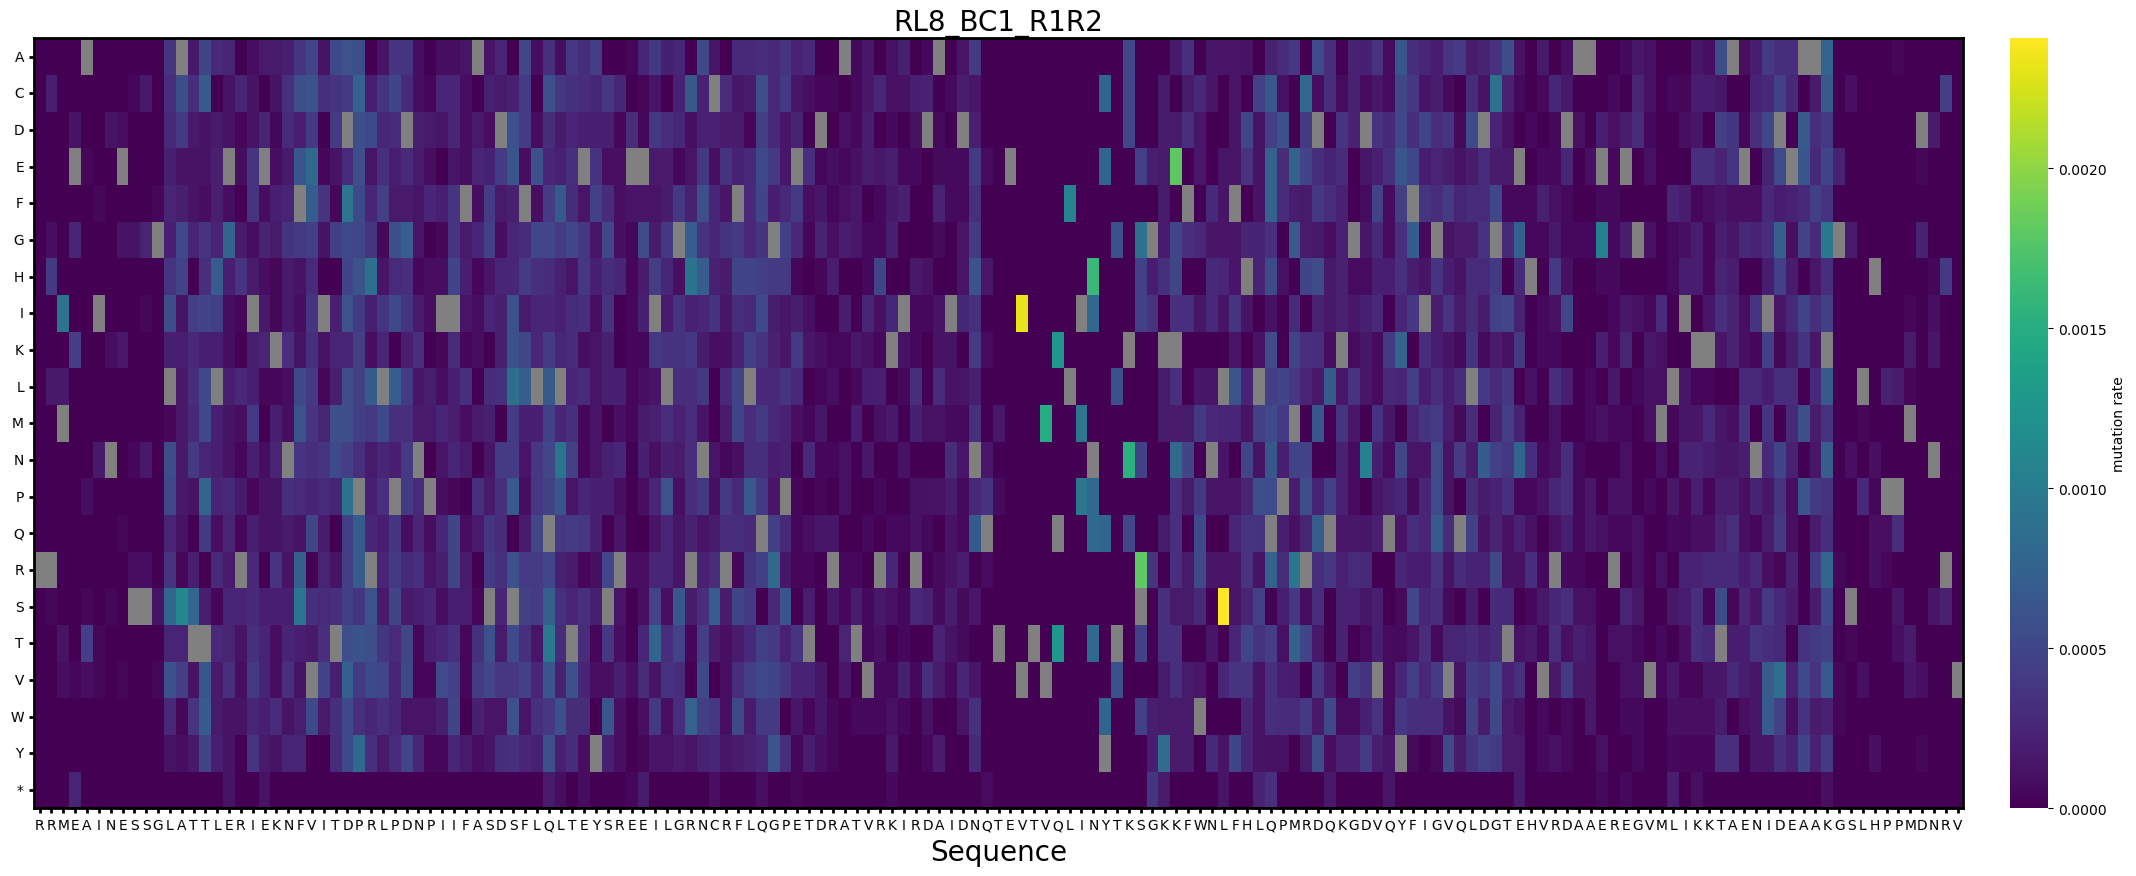

<Figure size 640x480 with 0 Axes>

In [5]:

plot_mutation_enrichment(total_relative_enrichment, ref_seq=reference, samplename=f"{variant}_{Bc}_R1R2", data_type="AA", FigFolder=FigFolder, vmax=None)

<Figure size 640x480 with 0 Axes>

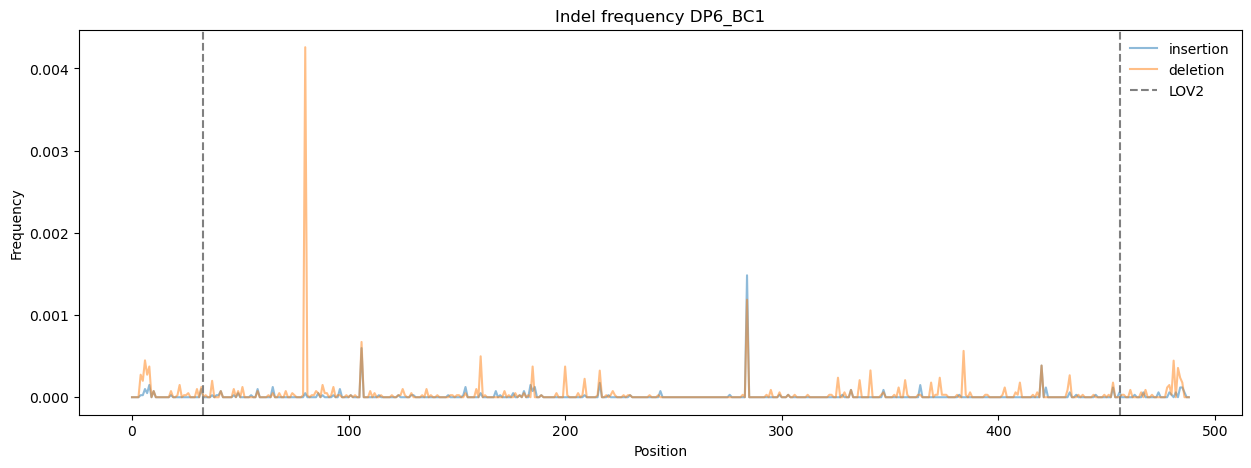

In [157]:
fig, axes = plt.subplots(1, figsize=(15,5))
plt.plot(total_indels.columns,total_indels.loc["insertion",:], label = "insertion", alpha = 0.5)
plt.plot(total_indels.columns,total_indels.loc["deletion",:], label = "deletion", alpha = 0.5)
plt.axvline(x=LOV2_endidx, color='grey', linestyle='--', label = "LOV2")
plt.axvline(x=LOV2_startidx, color='grey', linestyle='--')
plt.legend(frameon = False)
plt.xlabel("Position")
plt.ylabel("Frequency")
plt.title(f"Indel frequency {variant}_{Bc}")
plt.savefig(f"{FigFolder}/{variant}_{Bc}_R1_R2_indel_freq.pdf", bbox_inches='tight')
plt.show()

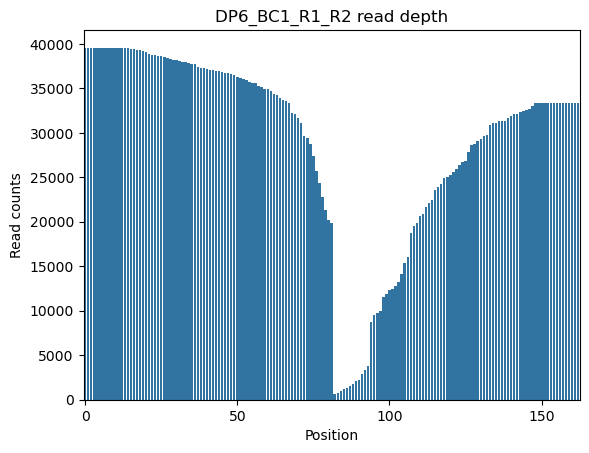

In [158]:
coverage_plot(total_variants.sum(), FigFolder=FigFolder, samplename = f"{variant}_{Bc}_R1_R2")

In [59]:
DP6_indels = pd.read_csv("/home/student/anna/DMS_analysis/output/final_output/DP6/blast/combined/enrichments/DNA/DP6_BC1_S1_combined_roiFalse_DNA_indel_freq.csv", index_col=0)
RL8_indels = pd.read_csv("/home/student/anna/DMS_analysis/output/final_output/RL8/blast/combined/enrichments/DNA/RL8_BC1_S1_combined_roiFalse_DNA_indel_freq.csv", index_col=0)  
RL8_mutations = pd.read_csv("/home/student/anna/DMS_analysis/output/final_output/RL8/blast/combined/enrichments/AA/RL8_BC1_S1_combined_roiFalse_AA_enrichment_relative.csv", index_col=0)
DP6_mutations = pd.read_csv("/home/student/anna/DMS_analysis/output/final_output/DP6/blast/combined/enrichments/AA/DP6_BC1_S1_combined_roiFalse_AA_enrichment_relative.csv", index_col=0)

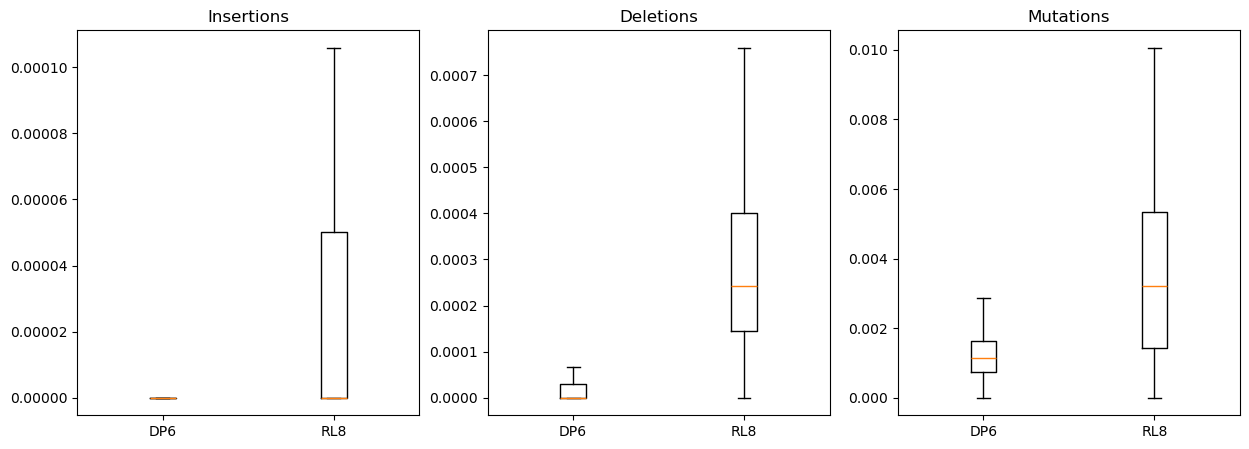

In [60]:

DP6_insertions = DP6_indels.loc["insertion",:DP6_indels.columns[200]]
RL8_insertions = RL8_indels.loc["insertion",: RL8_indels.columns[200]]
DP6_deletions = DP6_indels.loc["deletion",:DP6_indels.columns[200]]
RL8_deletions = RL8_indels.loc["deletion",:DP6_indels.columns[200]]
DP6_muts = DP6_mutations.copy().sum()
RL8_muts = RL8_mutations.copy().sum()


fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].boxplot([DP6_insertions, RL8_insertions], tick_labels = ["DP6", "RL8"], showfliers=False)
axes[0].set_title("Insertions")
axes[1].boxplot([DP6_deletions, RL8_deletions], tick_labels = ["DP6", "RL8"], showfliers=False)
axes[1].set_title("Deletions")
axes[2].boxplot([DP6_muts, RL8_muts], tick_labels = ["DP6", "RL8"], showfliers=False)
axes[2].set_title("Mutations")
plt.show()

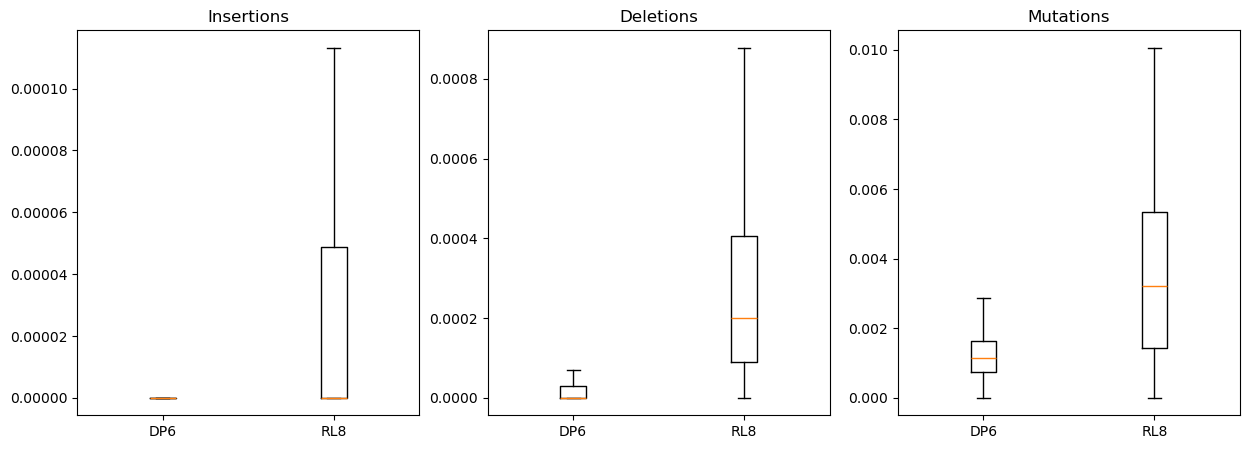

In [56]:
DP6_insertions = DP6_indels.loc["insertion",:]
RL8_insertions = RL8_indels.loc["insertion",:]
DP6_deletions = DP6_indels.loc["deletion",:]
RL8_deletions = RL8_indels.loc["deletion",:]
DP6_muts = DP6_mutations.sum()
RL8_muts = RL8_mutations.sum()

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].boxplot([DP6_insertions, RL8_insertions], tick_labels = ["DP6", "RL8"], showfliers=False)
axes[0].set_title("Insertions")
axes[1].boxplot([DP6_deletions, RL8_deletions], tick_labels = ["DP6", "RL8"], showfliers=False)
axes[1].set_title("Deletions")
axes[2].boxplot([DP6_muts, RL8_muts], tick_labels = ["DP6", "RL8"], showfliers=False)
axes[2].set_title("Mutations")
plt.show()

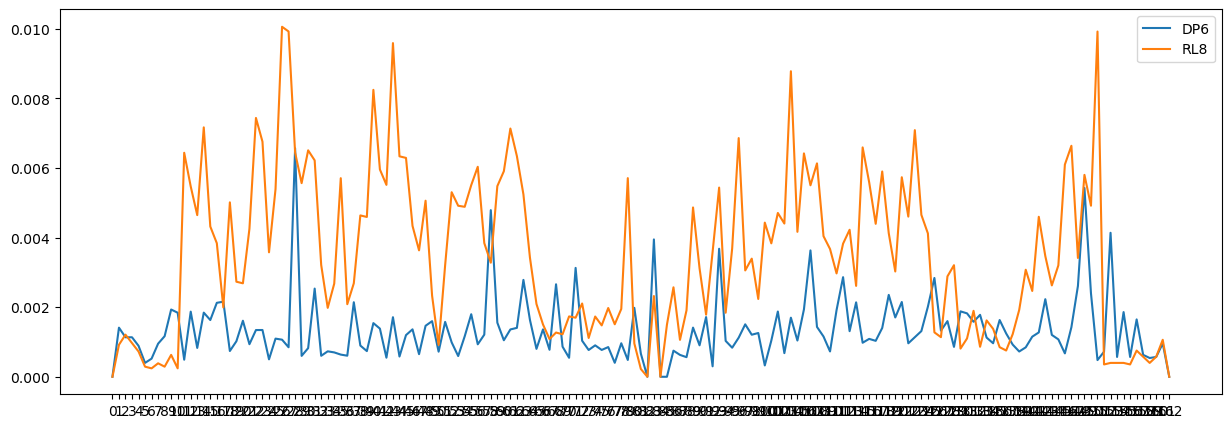

In [61]:
plt.figure(figsize=(15,5))
plt.plot(DP6_muts, label = "DP6")
plt.plot(RL8_muts, label = "RL8")
plt.legend()    
plt.show()

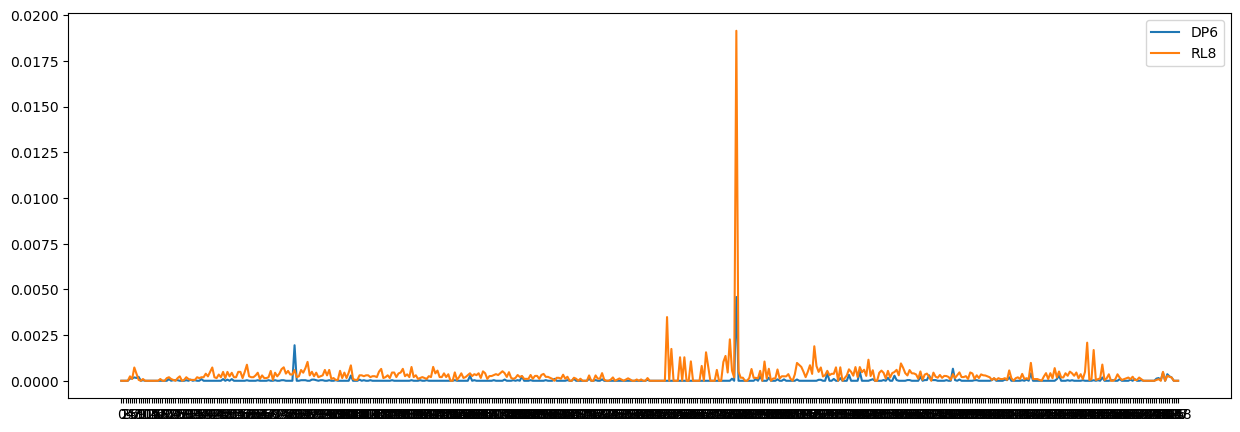

In [57]:
plt.figure(figsize=(15,5))
plt.plot(DP6_deletions, label = "DP6")
plt.plot(RL8_deletions, label = "RL8")
plt.legend()    
plt.show()


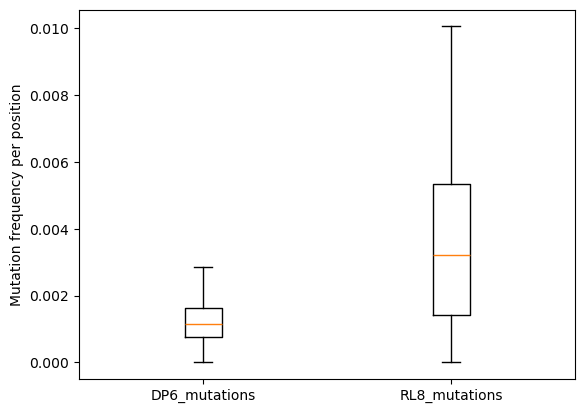

In [16]:
plt.boxplot([DP6_muts, RL8_muts], tick_labels = ["DP6_mutations", "RL8_mutations"], showfliers=False)
plt.ylabel("Mutation frequency per position")
plt.show()

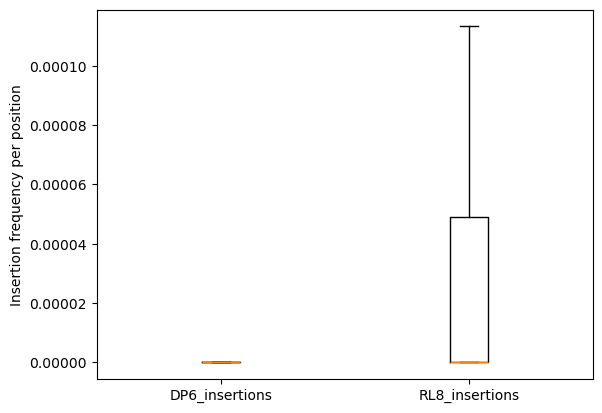

In [17]:
plt.boxplot([DP6_insertions, RL8_insertions], tick_labels = ["DP6_insertions", "RL8_insertions"], showfliers=False)
plt.ylabel("Insertion frequency per position")
plt.show()

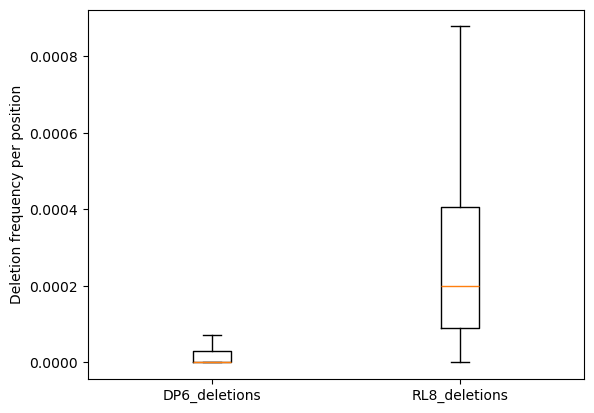

In [39]:
plt.boxplot([ DP6_deletions, RL8_deletions], tick_labels = ["DP6_deletions", "RL8_deletions"], showfliers=False)
plt.ylabel("Deletion frequency per position")
plt.show()

In [124]:
BC1_linkers = pd.read_csv("/home/student/anna/DMS_analysis/output/R36/blast00/R1/enrichments/AA/R36_BC1_S1_R1_AA_linker_distribution.csv", index_col=0).T
BC2_linkers = pd.read_csv("/home/student/anna/DMS_analysis/output/R36/blast00/R1/enrichments/AA/R36_BC2_S1_R1_AA_linker_distribution.csv", index_col=0).T
BC3_linkers = pd.read_csv("/home/student/anna/DMS_analysis/output/R36/blast00/R1/enrichments/AA/R36_BC3_S1_R1_AA_linker_distribution.csv", index_col=0).T

all_linkers_vars = list(set(list(BC1_linkers.columns) + list(BC2_linkers.columns)+ list(BC3_linkers.columns)))
all_linker_perc = pd.DataFrame(columns = all_linkers_vars, index = ["BC1", "BC2", "BC3"], data = 0, dtype=np.float64)

for linker in all_linkers_vars: 
    if linker in BC1_linkers.columns:
        all_linker_perc.loc["BC1", linker] = BC1_linkers.loc["percentage", linker]
    if linker in BC2_linkers.columns:
        all_linker_perc.loc["BC2", linker] = BC2_linkers.loc["percentage", linker] 
    if linker in BC3_linkers.columns:
        all_linker_perc.loc["BC3", linker] = BC3_linkers.loc["percentage", linker]


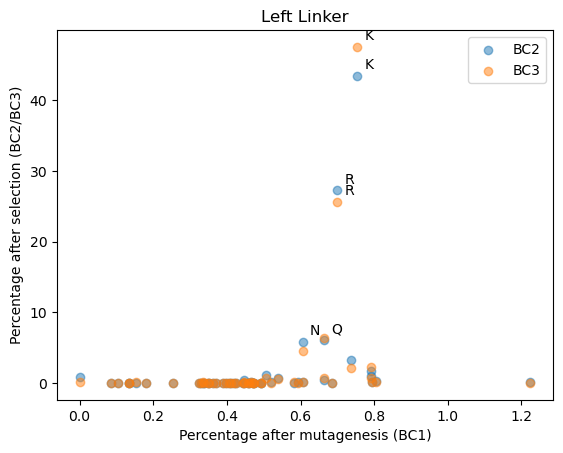

In [128]:
plt.scatter(all_linker_perc.loc["BC1",:], all_linker_perc.loc["BC2",:], label = "BC2", alpha = 0.5)
plt.scatter(all_linker_perc.loc["BC1",:], all_linker_perc.loc["BC3",:], label = "BC3", alpha = 0.5)
plt.xlabel("Percentage after mutagenesis (BC1)")
plt.ylabel("Percentage after selection (BC2/BC3)")

for i, (x, y) in enumerate(zip(all_linker_perc.loc["BC1", :], all_linker_perc.loc["BC2", :])):
    if y > 5:  
        plt.annotate(all_linker_perc.columns[i], (x, y), textcoords="offset points", xytext=(5,5), ha='left')
for i, (x, y) in enumerate(zip(all_linker_perc.loc["BC1", :], all_linker_perc.loc["BC3", :])):
    if y > 10:  
        plt.annotate(all_linker_perc.columns[i], (x, y), textcoords="offset points", xytext=(5,5), ha='left')
plt.legend(frameon = True)
plt.title("Left Linker")
plt.savefig("/home/student/anna/DMS_analysis/output/R36/blast00/R1/plots/AA/R36_linker_evolution_scatter.pdf", bbox_inches='tight')
plt.show()


In [133]:
BC1_linkers = pd.read_csv("/home/student/anna/DMS_analysis/output/R36/blast00/R2/enrichments/AA/R36_BC1_S1_R2_AA_linker_distribution.csv", index_col=0).T
BC2_linkers = pd.read_csv("/home/student/anna/DMS_analysis/output/R36/blast00/R2/enrichments/AA/R36_BC2_S1_R2_AA_linker_distribution.csv", index_col=0).T
BC3_linkers = pd.read_csv("/home/student/anna/DMS_analysis/output/R36/blast00/R2/enrichments/AA/R36_BC3_S1_R2_AA_linker_distribution.csv", index_col=0).T

all_linkers_vars = list(set(list(BC1_linkers.columns) + list(BC2_linkers.columns) + list(BC3_linkers.columns)))
all_linker_perc = pd.DataFrame(columns = all_linkers_vars, index = ["BC1", "BC2", "BC3"], data = 0, dtype=np.float64)

for linker in all_linkers_vars: 
    if linker in BC1_linkers.columns:
        all_linker_perc.loc["BC1", linker] = BC1_linkers.loc["percentage", linker]
    if linker in BC2_linkers.columns:
        all_linker_perc.loc["BC2", linker] = BC2_linkers.loc["percentage", linker] 
    if linker in BC3_linkers.columns:
        all_linker_perc.loc["BC3", linker] = BC3_linkers.loc["percentage", linker]


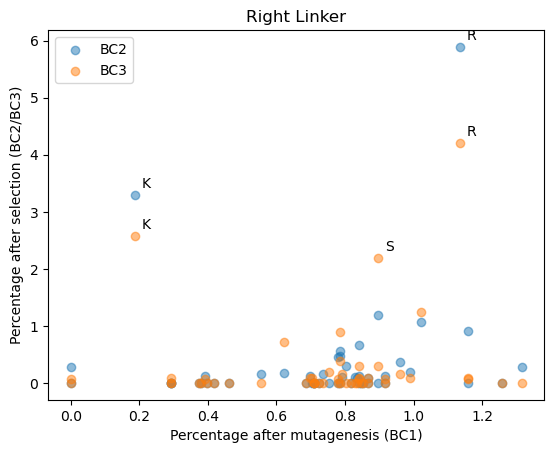

In [134]:
plt.scatter(all_linker_perc.loc["BC1",:], all_linker_perc.loc["BC2",:], alpha=0.5, label = "BC2")
plt.scatter(all_linker_perc.loc["BC1",:], all_linker_perc.loc["BC3",:], alpha=0.5, label = "BC3")
plt.legend(frameon = True)

plt.xlabel("Percentage after mutagenesis (BC1)")
plt.ylabel("Percentage after selection (BC2/BC3)")
plt.title("Right Linker")
for i, (x, y) in enumerate(zip(all_linker_perc.loc["BC1", :], all_linker_perc.loc["BC2", :])):
    if y > 2:  
        plt.annotate(all_linker_perc.columns[i], (x, y), textcoords="offset points", xytext=(5,5), ha='left')

for i, (x, y) in enumerate(zip(all_linker_perc.loc["BC1", :], all_linker_perc.loc["BC3", :])):
    if y > 2:  
        plt.annotate(all_linker_perc.columns[i], (x, y), textcoords="offset points", xytext=(5,5), ha='left')
plt.savefig("/home/student/anna/DMS_analysis/output/R36/blast00/R2/plots/AA/R36_linker_evolution_scatter.pdf", bbox_inches='tight')


plt.show()


In [394]:
RL8_mutations = pd.read_csv("/home/student/anna/DMS_analysis/output/final_output/RL8/blast/combined/enrichments/AA/RL8_BC1_S1_combined_roiFalse_AA_enrichment_relative.csv", index_col=0)
RL8_DNA_mutations = pd.read_csv("/home/student/anna/DMS_analysis/output/final_output/RL8/blast/combined/enrichments/DNA/RL8_BC1_S1_combined_roiFalse_DNA_enrichment_relative.csv", index_col=0)
RL8_encoded_muts = pd.read_csv("/home/student/anna/DMS_analysis/output/P0111_RetronLib/BC3_R1/blastpipeline/enrichments/BC3_RL_encoded_mutations.csv", index_col=0).T

In [370]:
RL8_observed_ref = "CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG"
## see /home/student/anna/DMS_analysis/data/fastq/P02_RL8_LOV2/references/RL8_BC1_S1_Nt_filt_ref.fasta

In [371]:
RL8_encoded_ref = "CAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGC"

In [372]:
cut_left = RL8_encoded_ref.index("CGCCGCATGGAAGCGATTAA")
cut_right = RL8_encoded_ref.index("TGGATAACCGCGTG") + len("TGGATAACCGCGTG")

In [395]:
RL8_encoded_muts = RL8_encoded_muts.iloc[:,cut_left:cut_right]

In [396]:
RL8_encoded_muts_prop = RL8_encoded_muts.iloc[0,:].values
RL8_encoded_muts_prop = RL8_encoded_muts_prop/RL8_encoded_muts_prop.sum()

In [314]:
# RL8_DNA_muts_prop = RL8_DNA_mutations.sum()
# RL8_DNA_muts_prop = RL8_DNA_muts_prop/RL8_DNA_muts_prop.sum()

In [397]:
RL8_DNA_muts_prop = RL8_DNA_mutations.sum()
## mask pos with max 
mask_max = np.where(RL8_DNA_muts_prop == RL8_DNA_muts_prop.max())[0][0]
RL8_DNA_muts_prop[mask_max] = np.nan
RL8_DNA_muts_prop = RL8_DNA_muts_prop/RL8_DNA_muts_prop.sum()



RL8_DNA_mutations_sum = RL8_DNA_mutations.sum()
RL8_DNA_mutations_sum[mask_max] = np.nan

/tmp/ipykernel_3498679/544745654.py:4: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  RL8_DNA_muts_prop[mask_max] = np.nan
/tmp/ipykernel_3498679/544745654.py:10: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  RL8_DNA_mutations_sum[mask_max] = np.nan


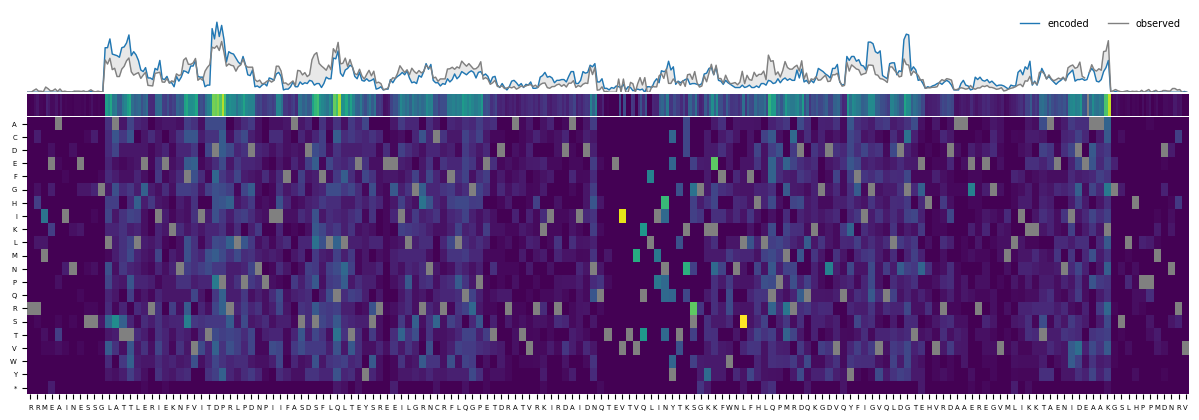

In [398]:
fig, axes = plt.subplots(3,1, figsize=(15, 5), height_ratios=[0.3, 0.08, 1])
## put plots closer together
plt.subplots_adjust(hspace=0.01)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)

axes[0].plot(RL8_encoded_muts_prop, label = "encoded", linewidth = 1)
axes[0].plot(RL8_DNA_muts_prop, label = "observed", linewidth = 1, color = "grey")
axes[0].set_xlim(0, len(RL8_encoded_muts.columns))
axes[0].set_ylim(0,0.012)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].legend(frameon = False, ncol=2, fontsize = 7)
axes[0].fill_between(range(len(RL8_encoded_muts_prop)), RL8_encoded_muts_prop, RL8_DNA_muts_prop, color="lightgray", alpha=0.5)

sns.heatmap(pd.DataFrame(RL8_DNA_mutations_sum).T, cmap= "viridis", cbar = False, ax = axes[1], xticklabels=False, yticklabels=False, vmax = 0.01)
axes[1].set_facecolor('gray')



sns.heatmap(RL8_mutations, cmap= "viridis", cbar = False, ax = axes[2],yticklabels=True,xticklabels=translate_dna2aa(RL8_observed_ref))
axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=1, fontsize = 5)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=1, fontsize = 5)
axes[2].set_facecolor('gray')
plt.savefig("/home/student/anna/DMS_analysis/output/final_output/RL8/RL8_encoded_vs_observed.pdf", bbox_inches='tight')
plt.savefig("/home/student/anna/DMS_analysis/output/final_output/RL8/RL8_encoded_vs_observed.png", bbox_inches='tight')

plt.show()